# Przewidywanie zwycięzcy turnieju sportowego z wykorzystaniem algorytmów eksploracji danych w tenisie

Projekt powstał na przedmiot **Eksploracja Danych** i ma na celu **przewidzenie zwyciężczyni turnieju tenisowego** (lub pojedynczych meczów) na podstawie historycznych danych meczowych. Zadanie to jest typową klasyfikacją binarną/multinomialną, którą można rozszerzyć do symulacji całej drabinki turniejowej (Monte-Carlo) w oparciu o prawdopodobieństwa pojedynczych pojedynków.

## Opis zbioru danych - *WTA Tennis 2007-2025 Daily Update*

- Zakres czasowy: 2007-05-01 → 2025-05-21 (codzienne aktualizacje)
- Rekordy: ≈ 70 000 spotkań WTA
- Atrybuty kluczowe: winner_id, loser_id, statystyki zagrywki (aces, df), punkty serwisowe/return, ranking WTA, nazwa turnieju, surface, round, best_of
- Źródło: https://www.kaggle.com/code/dissfya/wta-tennis-daily-update/notebook

Plik jest zbudowany na bazie publicznego repozytorium Jeffa Sackmanna i aktualizowany codziennie przez skrypt scrapujący stronę WTA.

## Przegląd literatury

## Inżynieria cech



Biblioteki uzyte w projekcie:

In [19]:
import kagglehub
import shutil
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from tqdm import tqdm

## Zapis danych

In [3]:
path = kagglehub.dataset_download("dissfya/wta-tennis-2007-2023-daily-update")

target_dir = "../data/"
os.makedirs(target_dir, exist_ok=True)

for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dst_file = os.path.join(target_dir, filename)
    shutil.copy2(src_file, dst_file)

print(f"Dane zostały zapisane do folderu: {target_dir}")

100%|██████████| 996k/996k [00:00<00:00, 1.68MB/s]

Extracting files...
Dane zostały zapisane do folderu: ../data/


## Sprawdzenie danych

In [6]:
df = pd.read_csv("../data/wta.csv")
df.head()

C:\Users\marta\AppData\Local\Temp\ipykernel_1332\2283637257.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/wta.csv")


,Tournament,Date,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
0,ASB Classic,2007-01-01 00:00:00,Outdoor,Hard,1st Round,3,Sun T.T.,Baker L.,Sun T.T.,81,272,332,90,1.33,3.00,6-1 6-1
1,ASB Classic,2007-01-01 00:00:00,Outdoor,Hard,1st Round,3,Myskina A.,Dulko G.,Dulko G.,16,59,1000,401,1.22,3.75,1-6 7-6 2-6
2,ASB Classic,2007-01-01 00:00:00,Outdoor,Hard,1st Round,3,Loit E.,Birnerova E.,Loit E.,56,84,418,324,1.72,2.00,6-1 6-1
3,ASB Classic,2007-01-01 00:00:00,Outdoor,Hard,1st Round,3,Nakamura A.,Craybas J.,Craybas J.,57,70,405,365,1.83,1.83,5-7 2-6
4,ASB Classic,2007-01-01 00:00:00,Outdoor,Hard,1st Round,3,Bartoli M.,Morita A.,Bartoli M.,18,180,951,152,1.16,4.50,7-6 6-3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42135 entries, 0 to 42134
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tournament  42135 non-null  object 
 1   Date        42135 non-null  object 
 2   Court       42135 non-null  object 
 3   Surface     42135 non-null  object 
 4   Round       42135 non-null  object 
 5   Best of     42135 non-null  int64  
 6   Player_1    42135 non-null  object 
 7   Player_2    42135 non-null  object 
 8   Winner      42135 non-null  object 
 9   Rank_1      42135 non-null  int64  
 10  Rank_2      42135 non-null  int64  
 11  Pts_1       42135 non-null  int64  
 12  Pts_2       42135 non-null  int64  
 13  Odd_1       42135 non-null  object 
 14  Odd_2       42135 non-null  float64
 15  Score       42135 non-null  object 
dtypes: float64(1), int64(5), object(10)
memory usage: 5.1+ MB


In [8]:
df.describe()

,Best of,Rank_1,Rank_2,Pts_1,Pts_2,Odd_2
count,42135.000000,42135.000000,42135.000000,42135.000000,42135.000000,42135.000000
mean,3.000047,76.242198,75.078723,1560.751893,1578.514109,2.512287
std,0.009743,93.783095,92.380957,1601.414814,1622.822300,2.083786
min,3.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000
25%,3.000000,24.000000,24.000000,627.000000,630.000000,1.400000
50%,3.000000,54.000000,53.000000,1025.000000,1032.000000,1.830000
75%,3.000000,96.000000,95.000000,1831.500000,1847.000000,2.750000
max,5.000000,1876.000000,1825.000000,13615.000000,13615.000000,51.000000


In [9]:
df.isna().sum()

Tournament    0
Date          0
Court         0
Surface       0
Round         0
Best of       0
Player_1      0
Player_2      0
Winner        0
Rank_1        0
Rank_2        0
Pts_1         0
Pts_2         0
Odd_1         0
Odd_2         0
Score         0
dtype: int64

## Wstępny check i czyszczenie

1. Szybkie czyszczenie

In [ ]:
# -> day time format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

In [12]:
# -> strip spacji z kolumn tekstowych
for col in ["Tournament", "Court", "Surface", "Round", "Player_1", "Player_2", "Winner", "Score"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

In [13]:
# -> usunięcie meczy RET/W.O/DEF
if "Score" in df.columns:
    df = df[~df["Score"].str.contains(r"RET|W/O|DEF", na=False)].reset_index(drop=True)

In [14]:
# -> standaryzacja nawierzchni
SURF_MAP = {
    "Hard Indoor": "Hard", "Carpet": "Hard",
    "Clay Indoor": "Clay",
}
df["Surface"] = df["Surface"].replace(SURF_MAP)

In [15]:
# -> court indoor/outdoor one‑hot
if "Court" in df.columns:
    df["Court_Outdoor"] = (df["Court"].str.contains("Outdoor", na=False)).astype(int)
    df = df.drop(columns=["Court"], errors="ignore")

In [16]:
# -> drop Best of (zawsze 3) ----------------------
df = df.drop(columns=["Best of"], errors="ignore")

2. Konwersacja numeryczna

In [17]:
NUM_COLS = [
    "Rank_1", "Rank_2", "Pts_1", "Pts_2", "Odd_1", "Odd_2",
    "Aces_1", "Aces_2", "DF_1", "DF_2",
]
for col in NUM_COLS:
    if col in df.columns:
        df[col] = (df[col].astype(str)
                          .str.replace(",", ".", regex=False)
                          .str.extract(r"([-+]?[0-9]*\.?[0-9]+)")
                          .astype(float))

3. Parsing wyniku – sety & gemy

In [20]:
SET_RE = re.compile(r"(\d+)[-:](\d+)")  # 7-6, 10–8 itp.

def parse_score(score: str):
    p1_sets = p2_sets = p1_gems = p2_gems = 0
    for a, b in SET_RE.findall(score):
        a, b = int(a), int(b)
        p1_gems += a;  p2_gems += b
        p1_sets += a > b
        p2_sets += b > a
    return p1_sets, p2_sets, p1_gems, p2_gems

sets = df["Score"].apply(parse_score).tolist()
cols = ["P1_sets", "P2_sets", "P1_gems", "P2_gems"]
df[cols] = pd.DataFrame(sets, index=df.index)

4. Rounds mapping

In [21]:
ROUND_MAP = {
    "Qualifying": 0, "1st Round": 1, "2nd Round": 2, "3rd Round": 3,
    "4th Round": 4, "Round Robin": 5, "Quarterfinals": 6,
    "Semifinals": 7, "The Final": 8, "Third Place": 9,
}
df["Round_encoded"] = df["Round"].map(ROUND_MAP)

5. Target: Player1_wins

In [22]:
df["Player1_wins"] = (df["Winner"] == df["Player_1"]).astype(int)

6. Feature engineering

In [23]:
# Rank / points diff
if {"Rank_1", "Rank_2"}.issubset(df.columns):
    df["Rank_diff"] = df["Rank_2"] - df["Rank_1"]
if {"Pts_1", "Pts_2"}.issubset(df.columns):
    df["Points_diff"] = df["Pts_1"] - df["Pts_2"]

In [24]:
# Rolling form (helper)
from collections import defaultdict

def add_form(df: pd.DataFrame, window: int = 10):
    wins_hist = defaultdict(list)
    form1, form2 = [], []
    for _, r in df.sort_values("Date").iterrows():
        p1, p2, w = r["Player_1"], r["Player_2"], r["Player1_wins"]
        f1 = wins_hist[p1][-window:]
        f2 = wins_hist[p2][-window:]
        form1.append((sum(f1)/len(f1)) if f1 else 0.5)
        form2.append((sum(f2)/len(f2)) if f2 else 0.5)
        wins_hist[p1].append(w)
        wins_hist[p2].append(1-w)
    df["P1_form_win"], df["P2_form_win"] = form1, form2
    return df

df = add_form(df)

In [25]:
# H2H diff (compact)
from itertools import repeat

def add_h2h(df: pd.DataFrame):
    h2h = defaultdict(int)
    diffs = []
    for _, r in df.sort_values("Date").iterrows():
        p1, p2, w = r["Player_1"], r["Player_2"], r["Player1_wins"]
        diffs.append(h2h[(p1, p2)] - h2h[(p2, p1)])
        h2h[(p1, p2)] += w
        h2h[(p2, p1)] += 1-w
    df["H2H_diff"] = diffs
    return df

df = add_h2h(df)

7. Elo (global + surface)

In [26]:
START_ELO, K = 1500, 32
from math import pow

def exp_score(a, b):
    return 1/(1+pow(10, (b-a)/400))

def add_elo(df: pd.DataFrame):
    elo_g, elo_s = defaultdict(lambda: START_ELO), {s: defaultdict(lambda: START_ELO) for s in df["Surface"].unique()}
    cols = {k: [] for k in ["Elo_p1","Elo_p2","Elo_diff","SurfElo_p1","SurfElo_p2","SurfElo_diff"]}
    for _, r in df.sort_values("Date").iterrows():
        p1, p2, srf, w = r["Player_1"], r["Player_2"], r["Surface"], r["Player1_wins"]
        e1, e2 = elo_g[p1], elo_g[p2]
        se1, se2 = elo_s[srf][p1], elo_s[srf][p2]
        for k, v in zip(cols, [e1, e2, e1-e2, se1, se2, se1-se2]):
            cols[k].append(v)
        # update
        elo_g[p1] += K*(w-exp_score(e1,e2))
        elo_g[p2] += K*((1-w)-exp_score(e2,e1))
        elo_s[srf][p1] += K*(w-exp_score(se1,se2))
        elo_s[srf][p2] += K*((1-w)-exp_score(se2,se1))
    for k,v in cols.items():
        df[k] = v
    return df

df = add_elo(df)

8. Zapis prepared

In [27]:
KEEP = [c for c in df.columns if c not in {"Score", "Winner"}]
df[KEEP].to_csv("../prepared_data/wta_prepared_eda_v2.csv", index=False)
print("✅ zapisano ../prepared_data/wta_prepared_eda_v2.csv – shape", df[KEEP].shape)

✅ zapisano ../prepared_data/wta_prepared_eda_v2.csv – shape (42135, 30)


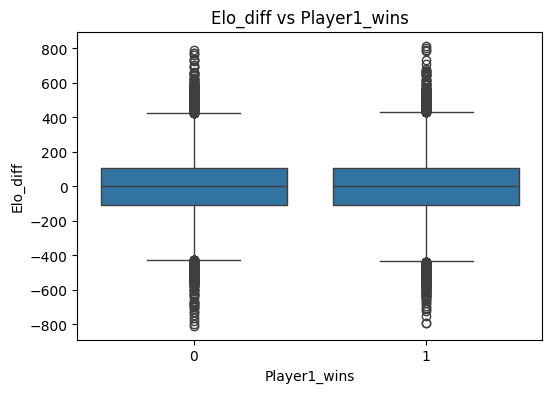

In [28]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Player1_wins"], y=df["Elo_diff"])
plt.title("Elo_diff vs Player1_wins")
plt.show()